In [1]:
import pvdeg
import numpy as np

## Create Scenario and Populate Location
The default geospatial datapoints for addLocation are from the Americas satellite. This is the only data we are interested in for this case so don't specify any location arguments.
To speed up calculations we will downsample to get coarser data. The downsampling function is not linear. A downsample factor of 10 takes us from 2018267 entries to only 5109.

In [2]:
features = pvdeg.scenario.GeospatialScenario(
    name='finding-features'
)

features.addLocation(downsample_factor=10)

/home/tford/.conda-envs/pvdeg_env/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "phony_dim_1" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


## Intro to KDTrees

A K dimensional tree is a datastructure for organizing n points in a k dimensional space. They are often used for nearest neighbors searches and many ML algorithms. Letting k = 2, our dimensions will be latitude and longitude. This is much faster than iterating over tabular data structures to find neighbors. The function to create a kdtree below requires scikit learn (also known as sklearn), a python machine learning library which is not included in the pvdeg dependency list so you will have to install it independently. Scipy also has a kdtree class but it is much slower. Depending on the number of datapoints the tree build time could be quite long but for our purposes, the cell below will be quick.

In [4]:
tree = pvdeg.geospatial.meta_KDtree(meta_df=features.meta_data)

## Remaining Points After Downsampling

Use `plot_coords` to see all latitude longitude coordinate pairs included in a scenario's metadata. You can provide corners of a bounding box to change the extent of the matplotlib plot.

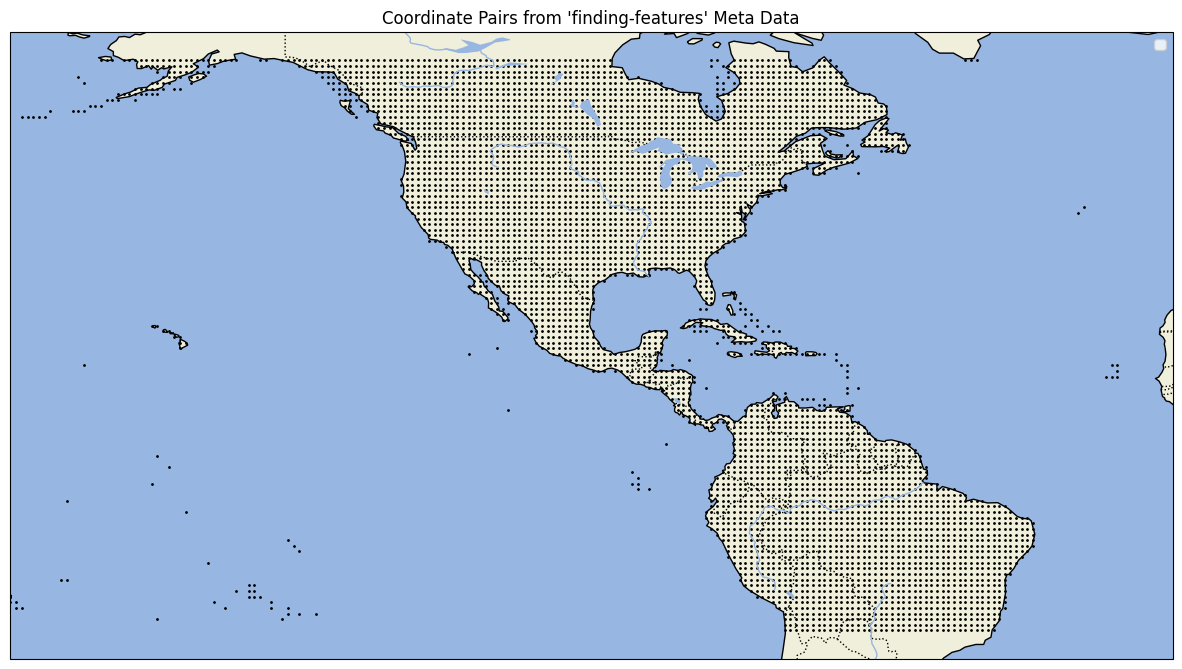

In [5]:
features.plot_coords()

# Identifying Mountains from Geospatial Data

Identify moutains by using the function below. There are currently 2 methods to identify mountains from our data. Both will add a column to our `GeospatialScenario.meta_data` attribute called `mountain` containing boolean values that represent if a data point is in/near mountains or not near mountains.

- `classify_mountains_weights` uses k nearest neighbors search and calculates local changes in height with different methods, the default is the `mean` absolute change compared to a points neighbors, then it assigns a weight to each point. If the remaining points are above the threshold then the percentile argument determines sensitivity to classifying points as mountains (higher weight, more mountainous). Much better than the following option.  
- `classify_mountains_radii` uses 2 nearest neighbors radius searches at each point and compares the average elevation of the inner circle to the avg radius of the circle. 

In [6]:
features.classify_mountains_weights(
    kdtree=tree
)

## Convience Plotting for Binary Classifications

the `plot_meta_classification` method allows you to plot your data with respect to a boolean classifier present in the `scenario.meta_data` dataframe columns.

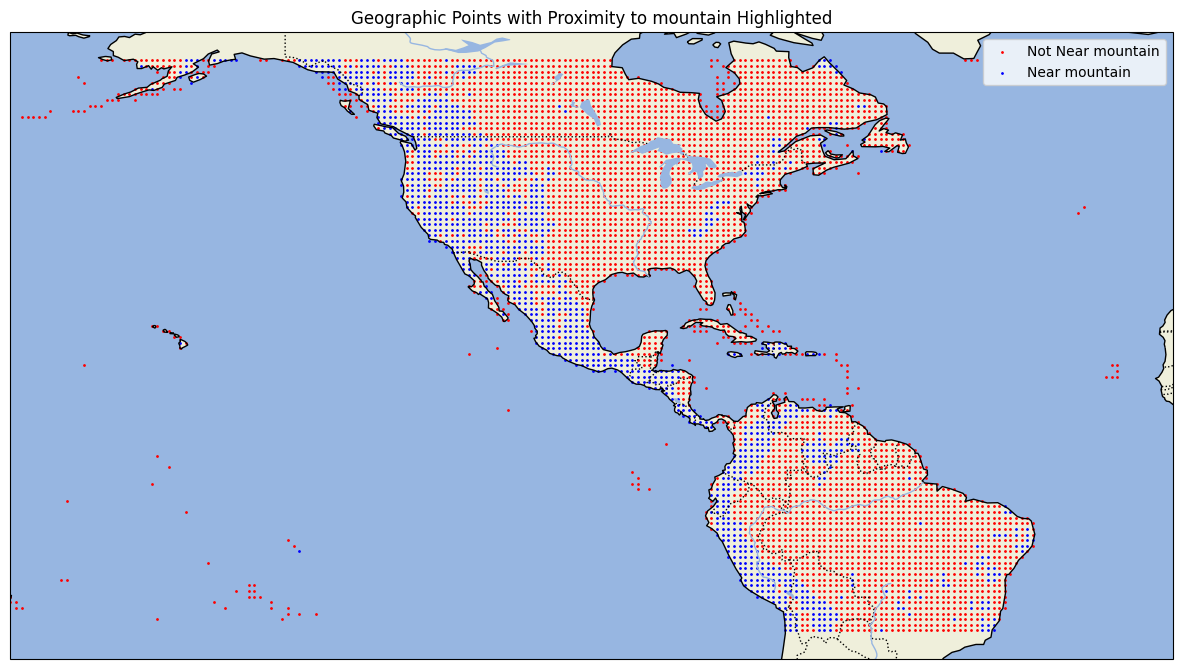

In [7]:
features.plot_meta_classification(col_name='mountain')

## Identifying mountains within a bounding box.

Sometimes we only want information from one area. To allow for more control over the selection process. To pick only one area from an existing superset of data we can use a bounding box. 
Either provide the top left and bottom right (latitude-longitude) pairs or a 2d numpy array of these pairs which will use the most extreme entries to form the bounding box.

In [9]:
features.classify_mountains_radii(
    kdtree=tree,
    elevation_floor=0,
    bbox_kwarg={'coords' : np.array([
    [47.960502, -115.048828],
    [47.842658, -101.118164],
    [36.738884, -113.686523],
    [36.633162, -100.283203],
    ])}
)

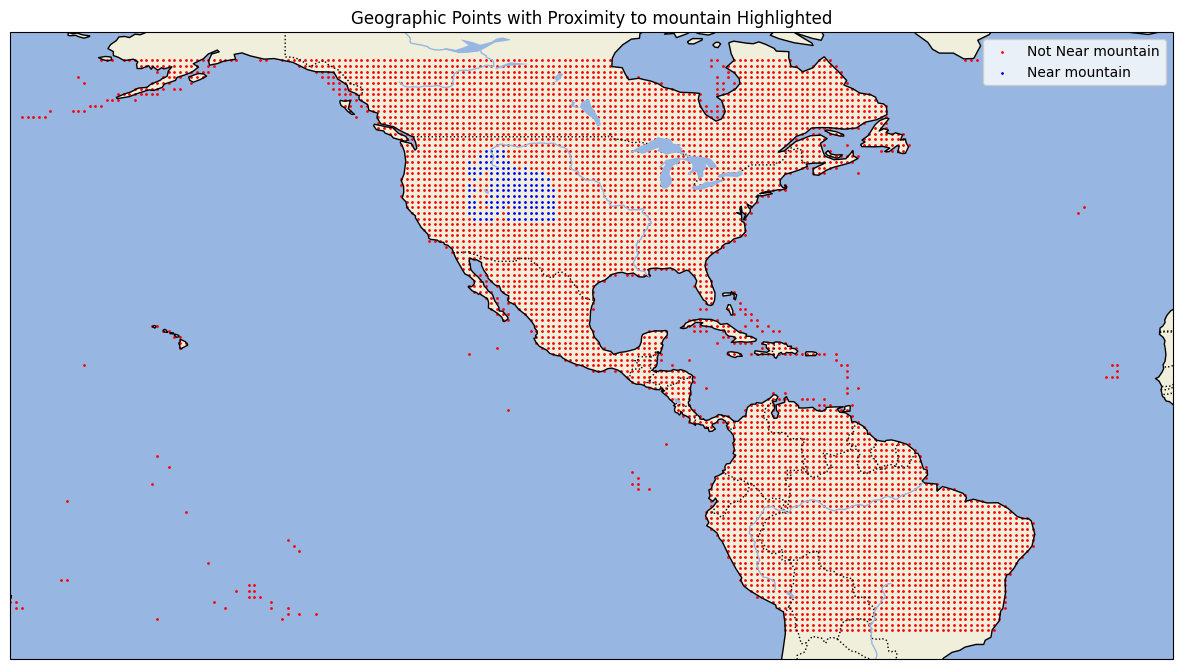

In [10]:
features.plot_meta_classification(col_name='mountain')

## Identifying Coastlines from Geospatial Data

To identify points within a search radius of any [natural earth features](https://www.naturalearthdata.com/features/). The following examples show the process of identifying coastline datapoints.

In [11]:
features.classify_feature(
    kdtree=tree,
    feature_name='coastline',
    resolution='10m',
    radius=0.5 # change this to get a wider band of selected data near the coastline
)

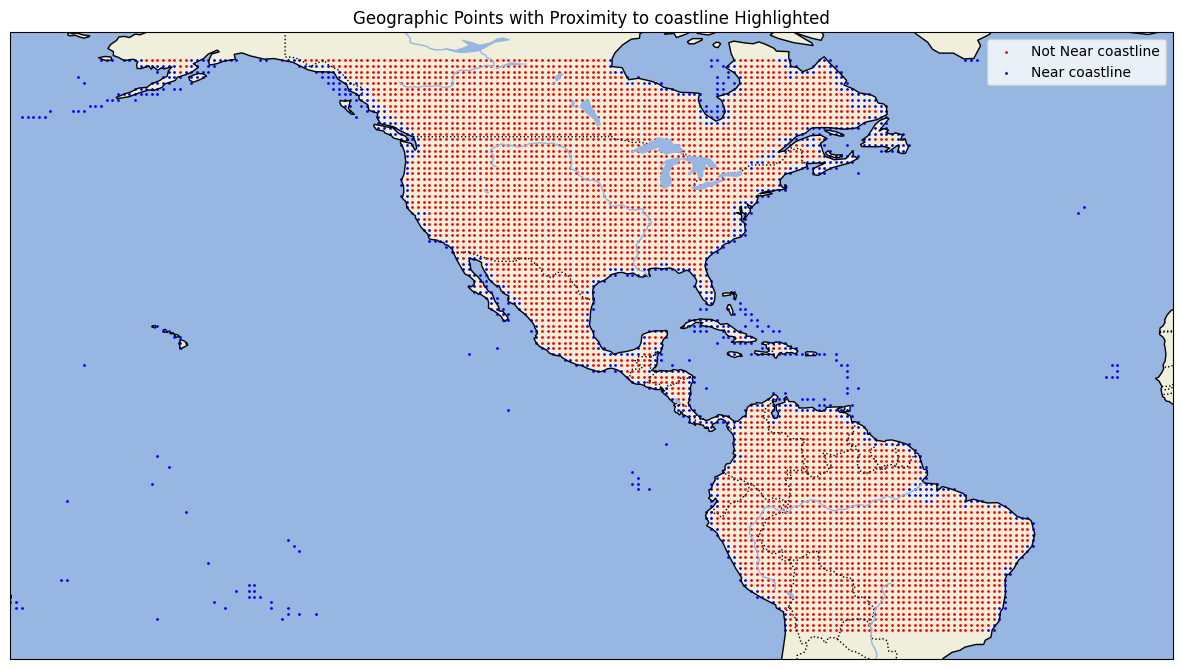

In [14]:
features.plot_meta_classification(col_name='coastline')

## Finding Rivers

Above we saw how to find points near coastlines, now lets do points near rivers. It is very similar

In [17]:
features.classify_feature(
    kdtree=tree,
    feature_name='rivers_lake_centerlines',
    resolution='10m',
    radius=0.2
)

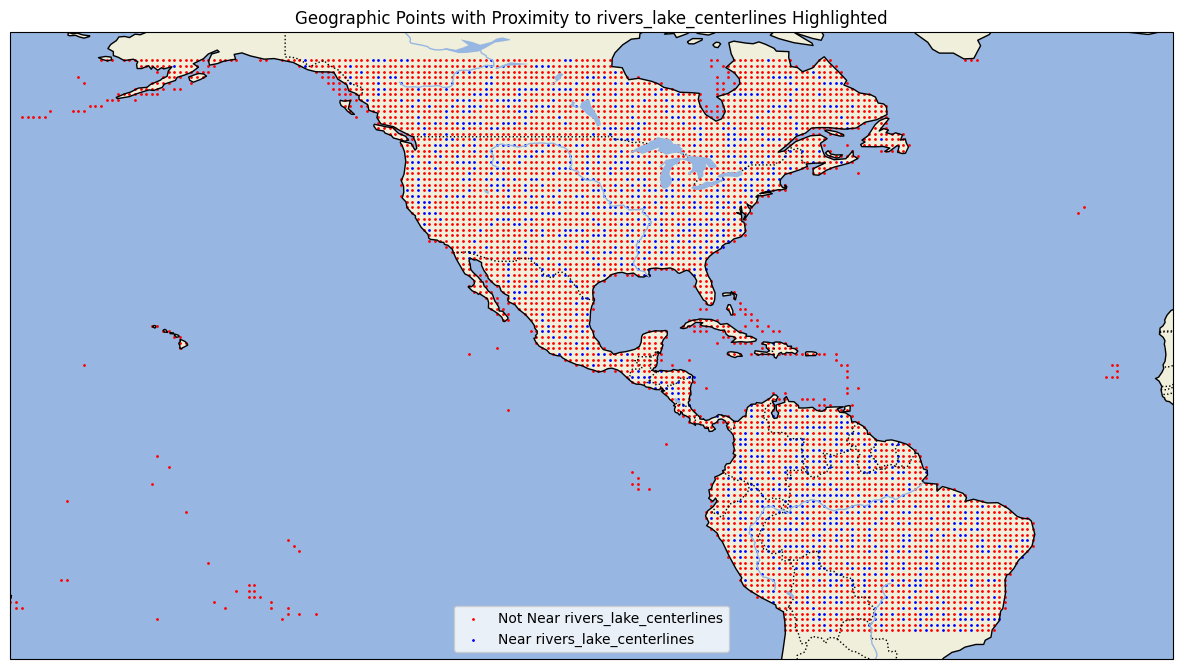

In [20]:
features.plot_meta_classification(col_name='rivers_lake_centerlines')